# DLIB Pose Estimation

Test the post for captures

In [4]:
from __future__ import division
import os, sys
from os.path import join
import cv2
import dlib
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageFile
import math
sys.path.insert(0,'/fileserver/Python/')
from utils import settings
from utils import imops
from utils import fileutils
from utils import imutils

In [490]:
def pltimg(im):
    plt.figure(figsize=(16,8))
    plt.xticks([]),plt.yticks([])
    plt.imshow(im)


def capture_compare_nose_deg( x, y):
    k = 'nose_deg'
    if x[k] < y[k]:
        return 0
    elif x[k] == y[k]:
        return 1
    else:
        return -1
    
    
def capture_compare_x( x, y):
    k = 'rx'
    if x[k] < y[k]:
        return 0
    elif x[k] == y[k]:
        return 1
    else:
        return -1
    
def capture_compare_y( x, y):
    k = 'ry'
    if x[k] < y[k]:
        return 0
    elif x[k] == y[k]:
        return 1
    else:
        return -1
    
def capture_compare_score( x, y):
    k = 'score'
    if x[k] < y[k]:
        return 0
    elif x[k] == y[k]:
        return 1
    else:
        return -1
    
def capture_compare_eye_deg( x, y):
    k = 'eye_deg'
    if x[k] < y[k]:
        return 0
    elif x[k] == y[k]:
        return 1
    else:
        return -1
    
def capture_compare_eyebrow( x, y):
    k = 'eyebrow_ratio'
    if x[k] < y[k]:
        return 0
    elif x[k] == y[k]:
        return 1
    else:
        return -1
    
def get_rot(im):
    # Load the most recent image
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    gray_bgr = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)

    # Detect face with dlib
    faces = imgops.detect_faces_dlib(gray,pyramids=0)
    if len(faces) > 0:
        face = faces[0]
    else:
        return None

    landmarks = imgops.get_landmarks(gray,roi=face) # Get landmarks
    x1,y1 = landmarks[36]
    x2,y2 = landmarks[45]
    
    from math import atan2, degrees, pi
    
    # Get eye angle
    dx = x2 - x1
    dy = y2 - y1
    rads = atan2(abs(dy),dx)
    rads %= 2*pi
    eye_deg = degrees(rads)

    # Get nose angle
    x1,y1 = landmarks[27]
    x2,y2 = landmarks[33]
    dx = x2 - x1
    dy = y2 - y1
    rads = atan2(abs(dy),dx)
    rads %= 2*pi
    nose_deg = degrees(rads)
    
    # Get head L/R tilt based on eyebrow size
    eb1 = float(abs(landmarks[17][0]-landmarks[21][0]))
    eb2 = float(abs(landmarks[45][0]-landmarks[42][0]))
    eyebrow_ratio = eb1/eb2
    
    
    
    pose_xyz = imgops.get_pose(gray_bgr,landmarks) # Get pose
    (success, rot_vec, tran_vec, cam_mat,pose_points) = imgops.get_pose(gray_bgr, landmarks)
    
    rot_vec_rad = [r[0] for r in rot_vec]
    rot_vec_rad_abs = [float(abs(r)) for r in rot_vec_rad]
    #rot_vec_rad_abs[0] = max(rot_vec_rad_abs[0],4)
    #rot_vec_rad_abs[0] /= 4
    #rot_vec_rad_abs[0] /= .75
    #rot_vec = [math.degrees(r[0]) for r in rot_vec]
    #rot_vec[0] = abs(rot_vec[0]-180)
    #rot_vec_abs = [abs(r) for r in rot_vec]
    #tran_vec_abs = [abs(r) for r in tran_vec]
    
    return {'rot':rot_vec_rad_abs, 'eye_deg':eye_deg,'nose_deg':nose_deg,
            'eyebrow_ratio':eyebrow_ratio}

In [491]:
a = [
    {'x':1,'name':'ok'},
    {'x':2,'name':'ok2'},
    {'x':3,'name':'ok3'}
]

a.sort(capture_compare_test,reverse=True)
a

[{'name': 'ok', 'x': 1}, {'name': 'ok2', 'x': 2}, {'name': 'ok3', 'x': 3}]

In [492]:
imgops = imops.ImageOps()

Init ImgeOps


In [493]:
fileserver = '/fileserver/'

cap_root = join(fileserver,'captures/20170605/8/101659272188')
captures = [f for f in os.listdir(cap_root) if not f.endswith('.json') and len(f) < 7]

fileserver = '/fileserver/'
#cap_root = join(fileserver,'captures/20170604/4')
#captures = [f for f in os.listdir(cap_root) if not f.endswith('.json')]
captures.sort(reverse=True)

print '{} captured people'.format(len(captures))

81 captured people


In [494]:
import math
def mag(x): 
    return math.sqrt(sum(i**2 for i in x))

def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

In [495]:
rots = []
rots_mag = []
for f in captures:
    try:
        #fpath = join(cap_root,f,'face.jpg')
        fpath = join(cap_root,f)
        im = cv2.imread(fpath)
        im.shape
    except:
        continue
    
    res = get_rot(im)
    if res is None:
        continue
    else:
        rx,ry,rz = res['rot']
        
    eye_deg = res['eye_deg']
    nose_deg = abs(res['nose_deg'] - 90)
    eyebrow_ratio = res['eyebrow_ratio']
    #print 'deg',deg

    score = rx * ry * (.33*rz)
    score_mag = rx * ry * rz
    #if nose_deg > 10:
    #    print nose_deg
    #    continue
    
    #if score > 3:
    #    print score
    #    continue
        
    rots.append({'fpath':fpath,'rx':rx,'ry':ry,'rz':rz,'score':score,
                 'eye_deg':eye_deg,'nose_deg':nose_deg,'eyebrow_ratio':eyebrow_ratio})


0.939452507467 3.16129502658 0.47971989801 0.619472553465 17.2131861323 2.32835820896


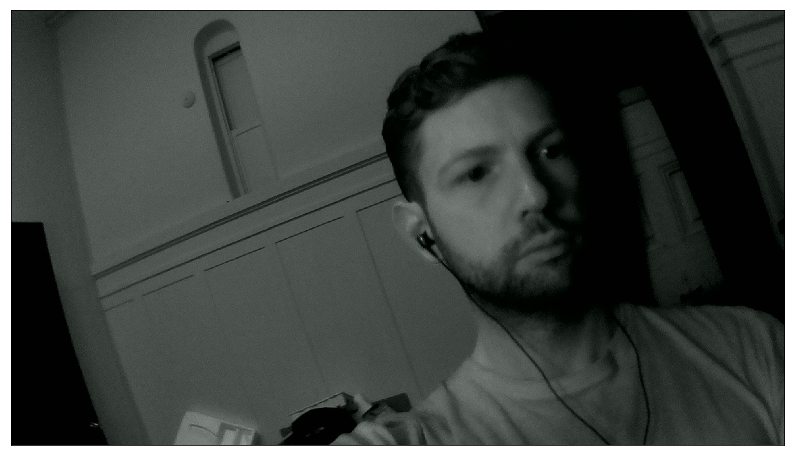

In [503]:
# Best

for r in rots:
    
    #r['score'] = (max(r['rx'],4)/4.0) * (max(r['ry'],0.5)/.5) * (max(r['rz'],1.0)/1.0)
    vec = ( max(r['rx'],4)/4.0, max(r['ry'],1.0)/1.0 , max(r['rz'],1.0)/1.0 )
    #r['score'] = mag( [r['rx'],r['ry'],r['rz']] )
    #r['score'] = mag( [r['rx'],r['ry']] )
    #r['score'] = r['rx']*r['ry']
    vec = ( r['rx'], r['ry'], r['rz'] )
    r['score'] = mag(vec)
    r['score'] = vec[0]*vec[1]*vec[2]
    #print r['score'], r['rx'], r['ry'],r['rz']

#rots.sort(capture_compare_nose_deg,reverse=True)

rots.sort(capture_compare_eyebrow,reverse=False)

#for r in rots[:50]:
#    print r['score'], r['rx'], r['ry'],r['rz'], r['deg']
    
i = 30
bestf = rots[i]['fpath']
r= rots[i]
im = cv2.imread(bestf)
print r['score'], r['rx'], r['ry'],r['rz'], r['eye_deg'],r['eyebrow_ratio']
pltimg(im)

In [497]:
# Best
i = 6
bestf = rots_mag[i]['fpath']
print rots_mag[i]
im = cv2.imread(bestf)
pltimg(im)

IndexError: list index out of range